**Plagiarism Policy**

NUS takes a strict view of plagiarism and considers it a serious form of academic dishonesty. Any student found to have engaged in such misconduct will be subjected to disciplinary action by the University. Please refer to the NUS Plagiarism Policy.

For assignments in BT4222, using any AI tools to **generate code or to verify your code** is not allowed. Sharing any part of the solution among students is not allowed either. Following the recently concluded plagiarism cases, if assignments were caught with a high degree of similarity, the presumption of guilt is applied when no hard evidence can be provided by the suspect.  

# BT4222 Assignment 3 (10 marks)

This assignment consists of 3 main questions.

- Question 1: Training a DNN image classifier for Fashion-MNIST data (**3.5 Marks**)
- Question 2: Training a CNN image classifier for CIFAR-10 data (**4 Marks**)
- Question 3: Ensemble learning for MNIST-784 data (**2.5 Marks**)

Submit this .ipynb file to: Canvas > Assignments > Assignment 3 by the deadline of March 13, 2359 (?). You should rename your file with your NUSNET ID, i.e. 'a0123456xx.ipynb'.

# Question 1: Training an Image Classifier Using Neural Network (3.5 marks)

We will be utilising Pytorch to train a neural network on an image classification problem. We will utilise the Fashion-MNIST image dataset. First, let's import Pytorch and matplotlib.

## Importing libraries

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

In [27]:
torch.__version__

'2.2.1+cu121'

## Data Loading

Pytorch has a number of functions to load popular datasets in `torchvision.datasets`. The following code loads the Fashion MNIST dataset using `torchvision.datasets.FashionMNIST`.
- PyTorch's built-in FashionMNIST dataset has 60,000 training images and 10,000 test images of 10 categories of clothing/fashion items.
- `torchvision.transforms.Compose` chains multiple transform steps
- `torchvision.transforms.ToTensor()` converts a PIL image or NumPy array to a PyTorch tensor. Specifically, it converts image data type to float32, scales pixel intensities to [0,1] range, converts a Height-Width-Channel formatted image to Channel-Height-Width tensor format.

In [28]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST('../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('../data', train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 10829084.57it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199918.74it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3625144.09it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12009052.83it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In fashion MNIST dataset, every image is represented as a 1× 28 × 28 array rather than a 1D array of size 784. Please check the length of the training dataset and the shape of first training image and its data type.

In [29]:
# should return: 60000 torch.Size([1, 28, 28]) torch.float32
print(len(train_dataset),train_dataset[0][0].shape, train_dataset[0][0].dtype)

60000 torch.Size([1, 28, 28]) torch.float32


## TASK 1.1 (0.1 marks)
Please plot an image from training dataset indexed at 20 using Matplotlib's `imshow()` function, with a `'binary'` color map.

Hint:
1. You need to convert the PyTorch tensor to a NumPy array.
2. You need to remove the channel dimension before plotting the image, as `imshow()` expects a 2D array for grayscale images.

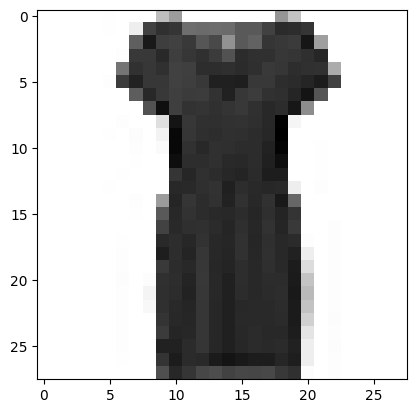

In [30]:
# Convert PyTorch tensor to NumPy array
image = torchvision.transforms.functional.to_pil_image(train_dataset[20][0])
image = np.array(image)

# Remove channel dimension
image = image.squeeze()

plt.imshow(image, cmap='binary')

## TASK 1.2 (0.1 marks)

The labels in target sets are the class IDs (represented as uint8), from 0 to 9, with class name shown in the following table.
Please create an array **class_name** containing class names for labels 0 to 9 sequentially. **(0.1 marks)**

Please output the class that the image at index 20 of the training set belongs to. **(0.1 marks)**

Hint:

```
Label Description
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot
```

In [31]:
class_name = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

label = train_dataset[20][1]
class_label = class_name[label]

Please output the class that the image at index 20 of the training set belongs to.

In [32]:
# your answer here
print("Class of the image at index 20:", class_label)

Class of the image at index 20: Dress


## TASK 1.3 (0.5 marks)

First, the original dataset does not include a separate validation set. It is thus crucial to partition the training set, `train_dataset`, into two subsets: a validation set, `val_dataset`, and a reduced training set, `train_dataset_new`. Specifically, a random selection of 5,000 data points should be allocated to `val_dataset`.

Second, verify and confirm the sizes of both `val_dataset` and `train_dataset_new` following the split.

Lastly, after splitting the datasets, it's essential to encapsulate `train_dataset_new`, `val_dataset`, and `test_dataset` within `DataLoader` objects, specifically creating `train_loader`, `val_loader`, and `test_loader`, using `torch.utils.data.DataLoader`.

Hint:
- For `train_loader`, variables `shuffle` should be set as True. Variables `batch_size` for all three dataloader should be set as 128. The validation and testing data should **not** be shuffled.
- The `DataLoader` class in PyTorch streamlines the process of batching and shuffling the data, making it easier and more efficient to feed the data into the neural network during training.

In [33]:
# partition train_dataset into val_dataset and train_dataset_new
N = len(train_dataset)
val_size = 5000
train_size = N - val_size

train_dataset_new, val_dataset = random_split(train_dataset, [train_size, val_size])

# verify that the size of train_dataset_new is 55000, and the size of the val_dataset is 5000.
print(len(train_dataset_new)==55000)
print(len(val_dataset)==5000)

# create train_loader, val_loader, test_loader
batch_size = 128
train_loader = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


True
True


## TASK 1.4 (0.8 marks)
Please build a classification neural network with two hidden layers. Instead of adding the layers one by one, you can pass a list of layers when creating the Sequential model **torch.nn.Sequential**. Here are the definition for each layer:
- the first layer is a Flatten layer whose role is to convert each input image into a 1D array. This layer does not have any parameters; it is just there to do some simple preprocessing. You can use `torch.nn.Flatten()`.
- Next you add a Dense hidden layer with **300** neurons. It will use the **ReLU** activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).
- Then you add a second Dense hidden layer with **100** neurons, followed by a batch normalization (BN) layer and a dropout layer with rate of 0.5. Again, the **ReLU** activation function will be applied here.
- Lastly, you add a Dense **output** layer with **10** neurons (one per class), using the **softmax** activation function.

In [34]:
# your answer here
model = nn.Sequential(
    nn.Flatten(), # Flatten the input images
    nn.Linear(28*28, 300),  # First hidden layer with 300 neurons
    nn.ReLU(),  # ReLU activation function
    nn.Linear(300, 100),  # Second hidden layer with 100 neurons
    nn.ReLU(),  # ReLU activation function
    nn.BatchNorm1d(100),  # Batch normalization layer
    nn.Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    nn.Linear(100, 10), # Output layer with 10 neurons for classification
    nn.Softmax(dim=1) # Softmax activation function
)

# Print the model architecture
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=100, out_features=10, bias=True)
  (8): Softmax(dim=1)
)


## TASK 1.5 (0.2 marks)

Use the sequential model’s `model.state_dict()[param_tensor].size()` to display all the model’s layers size.

In [35]:
layer_sizes = {param_tensor: model.state_dict()[param_tensor].size() for param_tensor in model.state_dict()}
layer_sizes

{'1.weight': torch.Size([300, 784]),
 '1.bias': torch.Size([300]),
 '3.weight': torch.Size([100, 300]),
 '3.bias': torch.Size([100]),
 '5.weight': torch.Size([100]),
 '5.bias': torch.Size([100]),
 '5.running_mean': torch.Size([100]),
 '5.running_var': torch.Size([100]),
 '5.num_batches_tracked': torch.Size([]),
 '7.weight': torch.Size([10, 100]),
 '7.bias': torch.Size([10])}

## TASK 1.6 (1.2 mark)

In this section, you will train the model via the following steps.

- You need to call `torch.optim` to define the optimizer, using **"ADADELTA"** and set **"lr"** as 1. (0.6 marks)

- You need to write a training process here:
  1. The training epochs should be set as 10.
  2. Put the model in train mode by using `model.train()`(vs eval mode). This matters for layers like BatchNorm or Dropout.
  3. During the training, you need to reset all gradients to zero before calculating new ones, as by default, gradients are accumulated. This can be done using `optimizer.zero_grad()`.
  4. Please use `F.cross_entropy()` to compute the loss function and perform backpropagation `backward()` on the loss.
  5. Then updates model weights based on accumulated gradients and the optimizer algorithm by using `optimizer.step()`

- You need to write a testing process to test and print the accuracy on the validation dataset during each training epoch. (0.6 marks)
  1. Put the model in evaluation mode by using `model.eval()` (vs training mode). This will disable dropout/batchnorm layers.
  2. Disables gradient calculation as we are only doing forward evaluation by using `torch.no_grad() `.
  3. Iterate through validation data batches (valid_loader).
  4. Run the data through the trained model to get predictions.
  5. Preduct the class with the maximum predicted probability from output for each image. Count the number of correct predictions.
  6. After the loop through all validation batches, displays the accuracy as percentage of validation set predictions that were correct.
  

In [36]:
# your answer here
optimizer = optim.Adadelta(model.parameters(), lr=1)

for epoch in range(1, 11):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()  # Reset gradients
        output = model(data)
        loss = F.cross_entropy(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

# Test loop
    model.eval()
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in val_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    print(f'Epoch {epoch}, Accuracy: {accuracy:.2f}%')

Epoch 1, Accuracy: 77.42%
Epoch 2, Accuracy: 79.16%
Epoch 3, Accuracy: 81.32%
Epoch 4, Accuracy: 85.10%
Epoch 5, Accuracy: 85.44%
Epoch 6, Accuracy: 84.20%
Epoch 7, Accuracy: 85.56%
Epoch 8, Accuracy: 85.28%
Epoch 9, Accuracy: 85.46%
Epoch 10, Accuracy: 86.74%


## TASK 1.7 (0.6 marks)
1. Calculate and print the testing accuracy. (0.1 mark)
2. Predict the class names of the first three instances in the test set. (0.5 mark)

In [37]:
#1
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Testing Accuracy: {:.2f}%'.format(accuracy * 100))

#2
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(3):
            print(f"Image {i+1}: {class_name[predicted[i]]}")
        break  # Only print the first batch

Testing Accuracy: 85.88%
Image 1: Ankle boot
Image 2: Pullover
Image 3: Trouser


# Question 2: Training an Image Classifier using Convolutional Neural Network (4 marks)

In this question, we will be utilising Pytorch to train a convolutional network on an image classification problem. We will utilise the coloured CIFAR-10 image dataset. The dataset has 60,000 images for 10 classes.

## Data Loading

In [38]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 42184041.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In CEFAR-10 dataset, every image is represented as a 3 x 32 x 32 array rather than a 1D array of size 3072. Please check the length of the training dataset and the shape of first training image and its data type, and output these values.

In [39]:
# should return 50000 torch.Size([3, 32, 32]) torch.float32
print(len(trainset),trainset[0][0].shape, trainset[0][0].dtype)

50000 torch.Size([3, 32, 32]) torch.float32


## TASK 2.1 (0.3 marks)
Please show the first 30 images in the train dataset using Matplotlib's imshow(), following a 5X6 layout (5 rows and 6 columns), and adding class name as the title for each image.

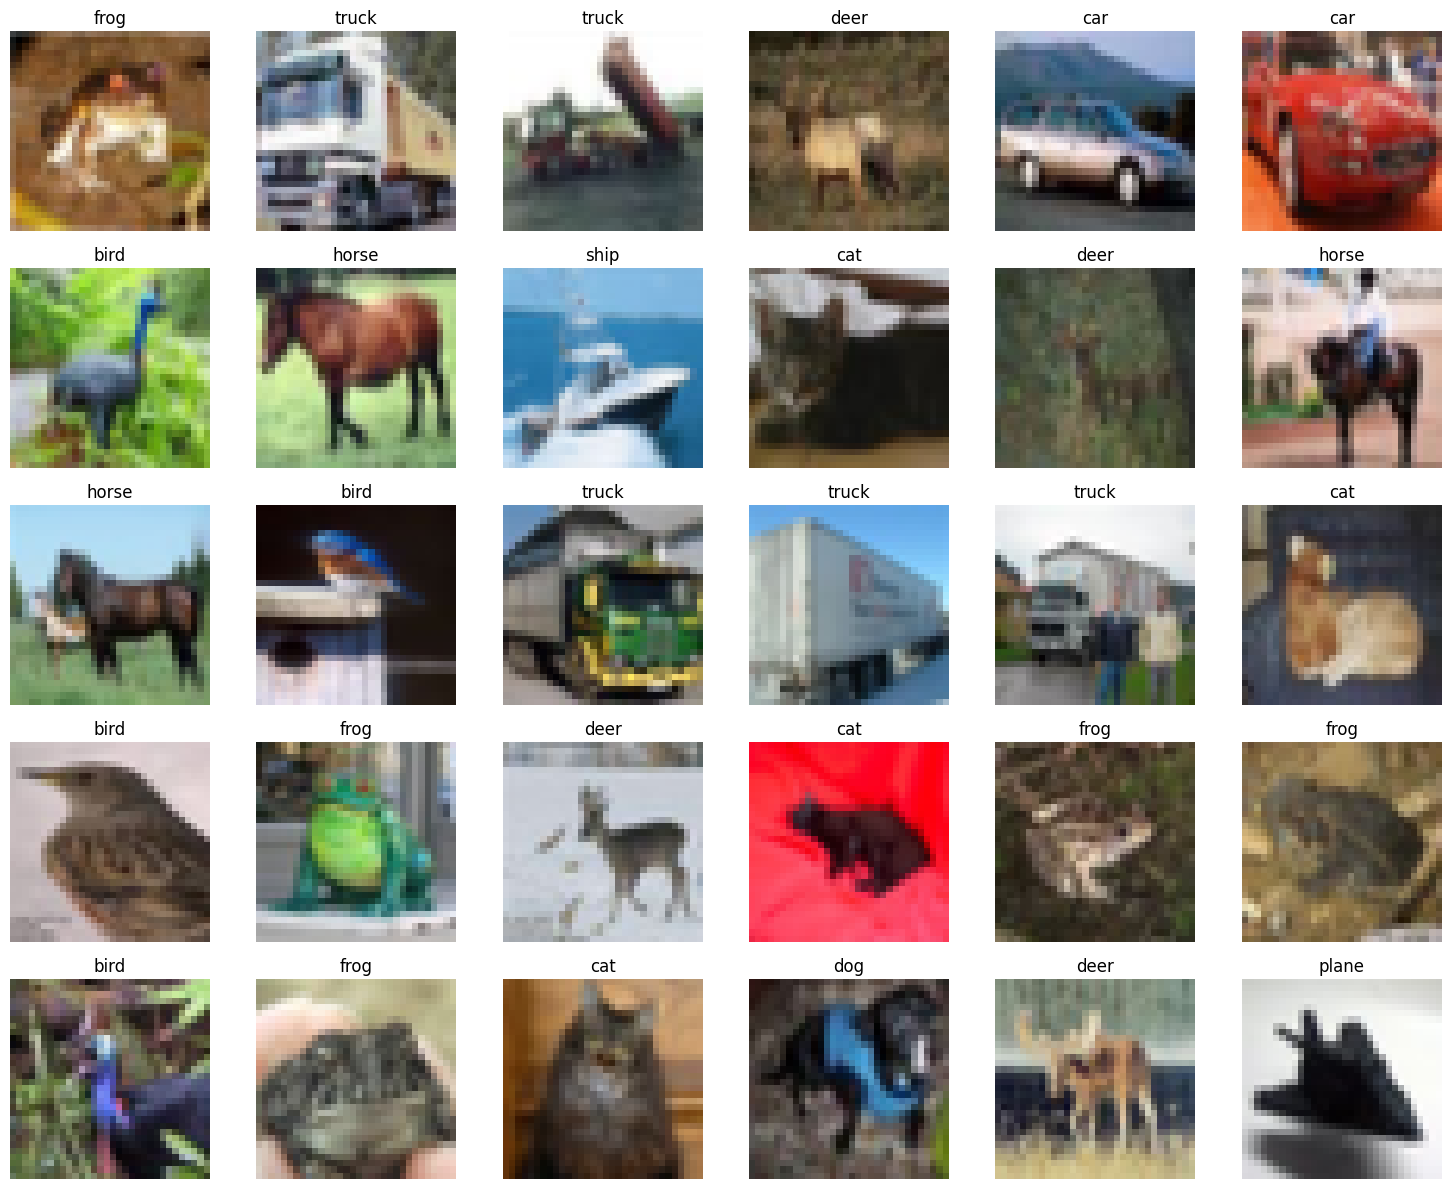

In [40]:
rows = 5
cols = 6

# Create a figure and axis
fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

# Loop through the first 30 images in the train dataset
for i in range(rows * cols):
    image, label = trainset[i]
    image = np.transpose(image.numpy(), (1, 2, 0))  # Transpose dimensions for RGB images
    ax = axs[i // cols, i % cols]
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

## TASK 2.2 (0.5 marks)
Please note that the original dataset does not include a separate validation set. Therefore, it's crucial to partition the training set, `trainset`, into two subsets: a validation set, `val_dataset`, and a reduced training set, `train_dataset_new`. Specifically, the size of val_dataset should be 0.2 of train_dataset.

After splitting the datasets, it's essential to encapsulate train_dataset_new, val_dataset, and test_dataset within DataLoader objects, specifically creating `trainloader`, `valloader`, and `testloader`, using `torch.utils.data.DataLoader`.

Hint:
- For trainloader, variables shuffle should be set as True. Variables batch_size for all three dataloader should be set as 128. The validation and testing data should **not** be shuffled.
- The DataLoader class in PyTorch streamlines the process of batching and shuffling the data, making it easier and more efficient to feed the data into the neural network during training.

In [41]:
# partition train_dataset into val_dataset and train_dataset_new
N = len(trainset)
val_size = int(0.2*N)
train_size = int(N*0.8)

train_dataset_new, val_dataset = random_split(trainset, [train_size, val_size])

# create trainloader, valloader, testloader
batch_size = 128
trainloader = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)





## TASK 2.3 (1 mark)

Please build a CNN model `baseline_CNN` with the following layers:

1. a Convolutional Layer with
*   3 input channels (RGB),
*   16 output channels,
*   3 x 3 kernel size,
*   stride of 1,
*   padding of 1

2. a Max Pooling Layer with
*   2 x 2 kernel size,
*   stride of 2,
*   padding of 0

3. a Fully Connected Layer with
*   input size of 16 x 16 x 16, which is calculated based on the output size of the previous Max Pooling layer after flattening,
*   output size of 64

4. an Output Layer with
* input size of 64, corresponding to the previous Fully Connected Layer,
* output size of 10, corresponding to the number of classes

5. a ReLU Activation Function.

The `forward` method in a PyTorch model defines the forward pass of the neural network. It describes how the input data flows through the layers of the network to produce an output. Define the `forward` method following the sequence in this image.

Note:

- Flatten the pooled feature map (after the pooling layer) into a size of 16 * 16 * 16 with the [view()](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view) function.
- Apply the activation function after the convolution layer.

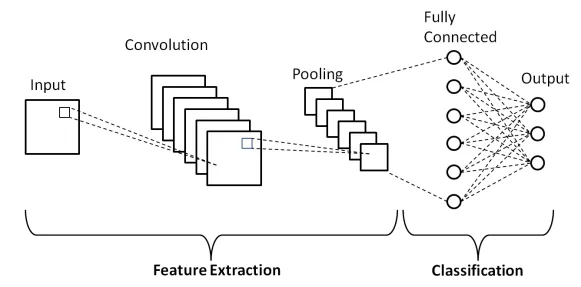

[Documentation](https://pytorch.org/docs/stable/nn.html)



In [42]:
class baseline_CNN(nn.Module):
    def __init__(self):
        super(baseline_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## TASK 2.4 (1 mark)

In this section, you will train the model via the following steps.

- You need to call `torch.optim` to define the optimizer. (Use **"SGD"** and set **"lr"** as 0.1)

- You need to write a training process here:
  The training epochs should be set as 10. Then follow the training steps provided in **Task 1.6**

- You need to write a testing process to test and print the accuracy on the validation dataset during each training epoch. You can follow the testing steps provided in **Task 1.6**

In [43]:
# instantiate your model
model = baseline_CNN()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(1, 11):
    model.train()
    for data, target in trainloader:
        optimizer.zero_grad()  # Reset gradients
        output = model(data)
        loss = F.cross_entropy(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

# Test loop
    model.eval()
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in valloader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / len(valloader.dataset)
    print(f'Epoch {epoch}, Accuracy: {accuracy:.2f}%')

Epoch 1, Accuracy: 36.64%
Epoch 2, Accuracy: 45.20%
Epoch 3, Accuracy: 50.41%
Epoch 4, Accuracy: 53.69%
Epoch 5, Accuracy: 52.97%
Epoch 6, Accuracy: 57.41%
Epoch 7, Accuracy: 54.80%
Epoch 8, Accuracy: 56.66%
Epoch 9, Accuracy: 58.45%
Epoch 10, Accuracy: 60.87%


## TASK 2.5 (0.2 marks)
Calculate and print the testing accuracy of your `baseline_CNN` model.

In [44]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Testing Accuracy: {:.2f}%'.format(accuracy * 100))

Testing Accuracy: 60.83%


## TASK 2.6 (1 mark)

Try to vary the layers of your `baseline_CNN` model such as adding more fully-connected layers, adding dropout, as well as tuning the hyperparameters of the model and optimizer used to create an `improved_CNN` model, which should have a higher testing accuracy than your `baseline_CNN` model.

Note: if the improvement in model performance is solely due to increasing the number of training epochs, no marks will be awarded for this question.

Calculate and print the testing accuracy of your `improved_CNN` model.

In [45]:
class improved_CNN(nn.Module):
    def __init__(self):
        super(improved_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten the output for the fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [46]:
# instantiate your model
model = improved_CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


for epoch in range(1, 11):
    model.train()
    for data, target in trainloader:
        optimizer.zero_grad()  # Reset gradients
        output = model(data)
        loss = F.cross_entropy(output, target)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

# Test loop
    model.eval()
    correct = 0
    with torch.no_grad():  # Disable gradient calculation
        for data, target in valloader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / len(valloader.dataset)
    print(f'Epoch {epoch}, Accuracy: {accuracy:.2f}%')

Epoch 1, Accuracy: 25.18%
Epoch 2, Accuracy: 34.19%
Epoch 3, Accuracy: 43.68%
Epoch 4, Accuracy: 48.67%
Epoch 5, Accuracy: 51.88%
Epoch 6, Accuracy: 51.16%
Epoch 7, Accuracy: 58.72%
Epoch 8, Accuracy: 59.69%
Epoch 9, Accuracy: 61.46%
Epoch 10, Accuracy: 62.77%


In [47]:
# test

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print('Testing Accuracy: {:.2f}%'.format(accuracy * 100))

Testing Accuracy: 62.53%


# Question 3: Ensemble learning for MNIST-784 data (2.5 Marks)

## Data Loading

The following code loads the MNIST data **mnist_784**, and splits it into a training set (50,000 instances), a validation set (10,000 instances), and a test set (10,000 instances).

In [48]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## TASK 3.1 (0.3 marks)
Please create three classifiers using sklearn, including a Random Forest classifier, a SVM classifier, and a Multi-layer Perceptron classifier (two hidden layer with size of 128 and 64 ). To reduce the elapsed time for SVM, you may set 100 as the maximum number of iterations to be run.

Hint:
You can use `sklearn.ensemble` (RandomForestClassifier), `sklearn.svm` (LinearSVC) and `sklearn.neural_network` (MLPClassifier).

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Random Forest Classifier
rf_classifier = RandomForestClassifier()

# SVM Classifier
svm_classifier = SVC(max_iter=100)

# Multi-layer Perceptron Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64))

## TASK 3.2 (0.2 marks)
- Train each of classifiers created in Task 3.1 using the training sets and `fit` (0.1 marks);
- Then report their accuracy on the validation sets using `score()` method (0.1 marks).

In [50]:
rf_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
mlp_classifier.fit(X_train, y_train)

rf_val_score = rf_classifier.score(X_val, y_val)
svm_val_score = svm_classifier.score(X_val, y_val)
mlp_val_score = mlp_classifier.score(X_val, y_val)

print("Random Forest Classifier Validation Accuracy:", rf_val_score)
print("SVM Classifier Validation Accuracy:", svm_val_score)
print("MLP Classifier Validation Accuracy:", mlp_val_score)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Random Forest Classifier Validation Accuracy: 0.9701
SVM Classifier Validation Accuracy: 0.9336
MLP Classifier Validation Accuracy: 0.9733


## Task 3.3 (0.5 marks)
- Use `VotingClassifier` from sklearn.ensemble to combine the three classifers into an ensemble classifier (0.3 mark)
- Then train the ensemble classifier on the training sets (0.1 mark)
- Obtain the accuracy on the validation sets (0.1 mark).

In [51]:
from sklearn.ensemble import VotingClassifier

ensemble_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('svm', svm_classifier),
        ('mlp', mlp_classifier)
    ],
    voting='hard'
)

ensemble_classifier.fit(X_train, y_train)

accuracy = ensemble_classifier.score(X_val, y_val)
print(f'Ensemble classifier accuracy on validation sets: {accuracy}')

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Ensemble classifier accuracy on validation sets: 0.9771


## TASK 3.4 (0.5 marks)
Try the ensemble classifier (the one trained in task 3.3) and the three individual classifiers (those trained in task 3.2) on the test sets respectively, and compare their accuracy. Please explicitly answer the classifier that achieves the best performance among all them.

In [52]:
# Evaluate the individual classifiers on the test set
rf_test_score = rf_classifier.score(X_test, y_test)
svm_test_score = svm_classifier.score(X_test, y_test)
mlp_test_score = mlp_classifier.score(X_test, y_test)

# Evaluate the ensemble classifier on the test set
voting_test_score = ensemble_classifier.score(X_test, y_test)

print("Random Forest Test Accuracy:", rf_test_score)
print("SVM Test Accuracy:", svm_test_score)
print("MLP Test Accuracy:", mlp_test_score)
print("Ensemble Classifier Test Accuracy:", voting_test_score)

best_score = max([rf_test_score, svm_test_score, mlp_test_score, voting_test_score])
best_classifier = None
if best_score == rf_test_score:
    best_classifier = "Random Forest"
elif best_score == svm_test_score:
    best_classifier = "SVM"
elif best_score == mlp_test_score:
    best_classifier = "MLP"
else:
    best_classifier = "Ensemble Classifier"
print("The classifier that achieves the best performance is:", best_classifier)


Random Forest Test Accuracy: 0.9652
SVM Test Accuracy: 0.9348
MLP Test Accuracy: 0.9683
Ensemble Classifier Test Accuracy: 0.9716
The classifier that achieves the best performance is: Ensemble Classifier


The best classifier is Ensemble Classifier

## TASK 3.5 (0.5 marks)
Create a new array from the validation set: the features are the predictions from the three individual classifiers, and the target variable is the image's class.

Hint:
- The predictions are from the individual classifiers (a Random Forest classifier, an SVM classifier, and a Multi-layer Perceptron classifier) trained in Task 3.2 on the validation set.
- The dimension of the new array should be (10,000, 3) without class or (10,000, 4) with class.

In [53]:
rf_predictions = rf_classifier.predict(X_val)
svm_predictions = svm_classifier.predict(X_val)
mlp_predictions = mlp_classifier.predict(X_val)


new_train_x = np.column_stack((rf_predictions, svm_predictions, mlp_predictions))

new_train_with_y = np.column_stack((new_train_x, y_val))

print("Shape of new array without class:", new_train_x.shape)
print("Shape of new array with class:", new_train_with_y.shape)

Shape of new array without class: (10000, 3)
Shape of new array with class: (10000, 4)


## TASK 3.6 (0.25 marks)
Use **RandomForestClassifier** to train a classifier on the new training set generated in Task 3.5, usng `out-of-bag` samples to estimate the generalization score. Please explicitly show the score of the training set as the answer.

In [54]:
stacking_classifier = RandomForestClassifier(
    n_estimators=100,
    oob_score=True , #out-of-bag
    random_state=42
    )

#train
stacking_classifier.fit(new_train_x, y_val)

training_score = stacking_classifier.score(new_train_x, y_val)
print("Training set score:", training_score)


Training set score: 0.9854


## TASK 3.7 (0.25 marks)
Finally, try the stacking classifier (the one trained in Task 3.6) on the test sets. Compare its accuracy with those obtained in Task 3.4. Please conclude which one of the classifiers, among the Random Forest classifier, the SVM classifier, the Multi-layer Perceptron classifier, the ensemble, or the stacking ensemble, is the best?

In [56]:
rf_predictions_test = rf_classifier.predict(X_test)
svm_predictions_test = svm_classifier.predict(X_test)
mlp_predictions_test = mlp_classifier.predict(X_test)


new_test_x = np.column_stack(
    (rf_predictions_test,
     svm_predictions_test,
     mlp_predictions_test)
    )

stacking_test_score = stacking_classifier.score(new_test_x, y_test)
print("Stacking Classifier Test Accuracy:", stacking_test_score)

Stacking Classifier Test Accuracy: 0.9701


In [58]:
print("Random Forest Test Accuracy:", rf_test_score)
print("SVM Test Accuracy:", svm_test_score)
print("MLP Test Accuracy:", mlp_test_score)
print("Ensemble Classifier Test Accuracy:", voting_test_score)

best_score = max([rf_test_score, svm_test_score, mlp_test_score, voting_test_score, stacking_test_score])
best_classifier = None
if best_score == rf_test_score:
    best_classifier = "Random Forest"
elif best_score == svm_test_score:
    best_classifier = "SVM"
elif best_score == mlp_test_score:
    best_classifier = "MLP"
elif best_score == voting_test_score:
    best_classifier = "Ensemble Classifier"
else:
    best_classifier = "stacking ensemble"

print("The classifier that achieves the best performance is:", best_classifier, best_score)


Random Forest Test Accuracy: 0.9652
SVM Test Accuracy: 0.9348
MLP Test Accuracy: 0.9683
Ensemble Classifier Test Accuracy: 0.9716
The classifier that achieves the best performance is: Ensemble Classifier 0.9716


#### Your conclusion: The classifier that achieves the best performance is the Ensemble Classifier at an accuracy score of 0.9716
